# Fingerprints Quality Classification
## DNN Course JCE - Final Project 
### By Kobi Amsellem & Zohar Kedem

Expirements:
* Try to classify 5 classes that represat the quality of the finger print (0 poor, 4 best)

In [1]:
# Relevenat imports
import numpy as np
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix as confusion_mtrx
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, Adamax, Nadam

**Hyperparameters**

In [2]:
seed=9
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
beta_1s=[
    0.9, 
    0.8, 
    0.7]
beta_2s=[
    0.999, 
    0.888, 
    0.777]
optimizers = [
    Adam, 
    Nadam]
optimizers_names = [
    'Adam', 
    'Nadam']
epochs_find_hypers = 10
epochs_best_hypers = 100
batch_size = 32
img_height = 180
img_width = 180
train_split = 0.7
validation_split = 0.15
test_split = 0.15


**Loading data to train and validation tensors**

Total:  976  examples
Found 976 files belonging to 5 classes.
Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB

train 21
val 5
test 5


2022-02-03 02:01:43.631325: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-03 02:01:43.632191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-03 02:01:43.632550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


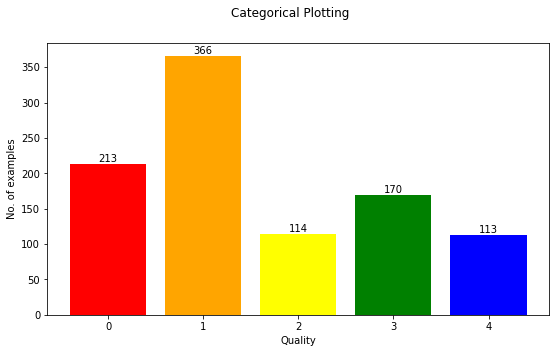

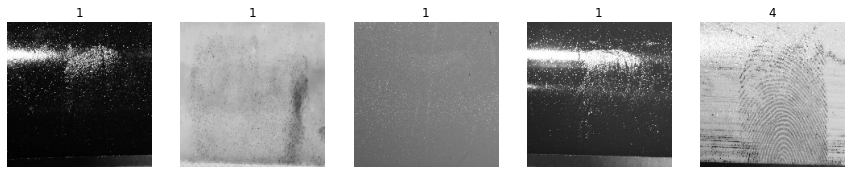

In [3]:
dirs = !ls Dataset

data_dir = pathlib.Path('./Dataset')
DATASET_SIZE = len(list(data_dir.glob('*/*.jpg')))
print('Total: ', DATASET_SIZE, ' examples')


counts = []
for dir in dirs:
  ddir = pathlib.Path('./Dataset/'+dir+'/')
  counts.append(len(list(ddir.glob('*.jpg'))))

fig, axs = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
c = ['red', 'orange', 'yellow', 'green', 'blue']
axs.bar(dirs, counts, color=c)
axs.set_ylabel('No. of examples')
axs.set_xlabel('Quality')
axs.bar_label(axs.containers[0])
fig.suptitle('Categorical Plotting')

full_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred',
  label_mode='categorical',
  )

train_size = int(train_split * (DATASET_SIZE/batch_size))
val_size = int(validation_split * (DATASET_SIZE/batch_size))
test_size = int(test_split * (DATASET_SIZE/batch_size))

full_dataset = full_dataset.shuffle(seed)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size+1)
test_dataset = test_dataset.take(test_size+1)

print("train", len(train_dataset))
print("val", len(val_dataset))
print("test", len(test_dataset))

train_dataset = train_dataset
val_dataset = val_dataset
test_dataset = test_dataset


plt.figure(figsize=(15, 5))
for images, labels in train_dataset.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(np.argmax(labels[i].numpy()))
    plt.axis("off")


**Data Augmentation**
Set sequential data augmentation pipeline:

* Random Rotation
* Random Flip
* Random Contrast

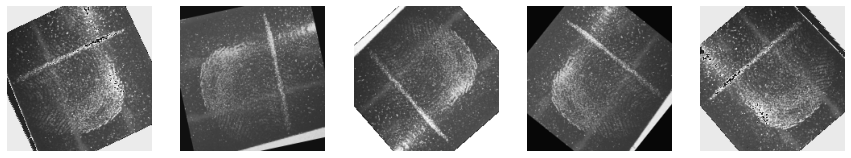

In [4]:
data_augmentation = Sequential()
data_augmentation.add(layers.RandomFlip(mode="horizontal_and_vertical", seed=seed))
data_augmentation.add(layers.RandomRotation((0,1),fill_mode="constant",interpolation="bilinear",seed=seed,fill_value=0.0))
data_augmentation.add(layers.RandomContrast(0.4, seed=None))

plt.figure(figsize=(15, 5))
with tf.device('/cpu:0'):
    for images, _ in train_dataset.take(1):
        for i in range(5):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [5]:
pretrained_models_names = ['EfficientNetB2', 'Xception', 'InceptionV3']
pretrained_models = [tf.keras.applications.EfficientNetB2, tf.keras.applications.Xception, tf.keras.applications.InceptionV3]

for i in range(len(pretrained_models)):
    pretrained_models[i] = pretrained_models[i](
                        include_top=False,
                        input_shape=(180,180,3),
                        pooling='avg',classes=5,
                        weights='imagenet')
    for layer in pretrained_models[i].layers:
        layer.trainable=False

In [6]:
custom_classifier = Sequential()
custom_classifier.add(layers.Flatten())
custom_classifier.add(layers.Dense(512, activation='relu'))
custom_classifier.add(layers.Dropout(0.4))
custom_classifier.add(layers.Dense(128, activation='relu'))
custom_classifier.add(layers.Dropout(0.3))
custom_classifier.add(layers.Dense(32, activation='relu'))
# custom_classifier.add(layers.Dropout(0.2))
custom_classifier.add(layers.Dense(5, activation='softmax'))

In [7]:
best_model_acc = 0
best_model_hyp = {}
best_model_history = {}
models_history = []

flag = False
for pretrained_model, model_name in zip(pretrained_models, pretrained_models_names):
    for optimizer, optimizer_name in zip(optimizers, optimizers_names):
        for learning_rate in learning_rates:
            for beta_1, beta_2 in zip(beta_1s, beta_2s):

                cur_pre_model = tf.keras.models.clone_model(pretrained_model)

                
                tmp_model = Sequential(
                    cur_pre_model
                )
                tmp_model.add(tf.keras.models.clone_model(custom_classifier))
                tmp_model.build((None, 180, 180, 3))
                tmp_model.compile(optimizer=optimizer(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2),loss='categorical_crossentropy',metrics=['accuracy'])
                history = tmp_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_find_hypers, verbose=0)

                model_hyps = {'model_name': model_name, 
                            'pretrained_model': tmp_model, 
                            'learning_rate': learning_rate, 
                            'beta_1':beta_1, 'beta_2': beta_2, 
                            'train_acc': history.history['accuracy'][-1],
                            'train_loss': history.history['loss'][-1],
                            'val_acc': history.history['val_accuracy'][-1],
                            'val_loss': history.history['val_loss'][-1],
                            'optimizer': optimizer,
                            'optimizer_name': optimizer_name
                            }
                if best_model_acc < history.history['val_accuracy'][-1]:
                    best_model_acc = history.history['val_accuracy'][-1]
                    best_model_hyp = model_hyps
                    best_model_history = history
                models_history.append(model_hyps)
                print("Model: ", model_name, ", Optimizer: ", optimizer_name, ", Learning rate: ", learning_rate, 
                        ", Beta1: ", beta_1, ", Beta2: ", beta_2, " ------ Validation Accuracy:", history.history['val_accuracy'][-1])            
                

2022-02-03 02:02:01.019701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:02:07.334269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.39375001192092896


2022-02-03 02:03:00.677049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:03:06.373505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4375


2022-02-03 02:04:00.796308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:04:07.088159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4375


2022-02-03 02:05:03.210089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:05:10.640132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4861111044883728


2022-02-03 02:06:06.728064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:06:14.830144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3611111044883728


2022-02-03 02:07:12.241417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:07:20.393403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.375


2022-02-03 02:08:17.520750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:08:26.920010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4437499940395355


2022-02-03 02:09:26.388844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:09:34.883857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3687500059604645


2022-02-03 02:10:34.876608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:10:45.761929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.36250001192092896


2022-02-03 02:11:45.372573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:11:55.567428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3687500059604645


2022-02-03 02:12:59.153254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:13:12.065298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3375000059604645


2022-02-03 02:14:16.375879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:14:28.750344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4124999940395355


2022-02-03 02:15:46.928447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:16:35.555979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3958333432674408


2022-02-03 02:18:39.413822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:19:21.816594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3402777910232544


2022-02-03 02:21:23.373081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:22:17.716351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4312500059604645


2022-02-03 02:24:32.569273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:25:24.485974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3499999940395355


2022-02-03 02:27:37.515068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:28:34.096636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3819444477558136


2022-02-03 02:30:56.707789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:31:51.067007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.375


2022-02-03 02:34:10.393830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:35:13.373969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3263888955116272


2022-02-03 02:37:41.770615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:38:51.502834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.45625001192092896


2022-02-03 02:41:28.941082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:42:31.375845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.409722238779068


2022-02-03 02:45:17.645818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:46:55.553378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3812499940395355


2022-02-03 02:49:37.559029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:51:19.182902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3819444477558136


2022-02-03 02:54:06.523779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 02:56:01.005901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4236111044883728


2022-02-03 02:59:10.108914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:01:00.162852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3819444477558136


2022-02-03 03:03:51.824221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:05:56.517862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3194444477558136


2022-02-03 03:08:06.025321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:10:11.073526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3819444477558136


2022-02-03 03:12:51.247058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:14:57.888442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4027777910232544


2022-02-03 03:18:18.872736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:20:27.202077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3888888955116272


2022-02-03 03:23:56.242430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:26:11.250133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3888888955116272


2022-02-03 03:29:41.086747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:31:50.967660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4027777910232544


2022-02-03 03:35:06.392871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:37:15.992123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3611111044883728


2022-02-03 03:40:43.827376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:42:38.705693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.36250001192092896


2022-02-03 03:46:15.567180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:48:19.076353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3888888955116272


2022-02-03 03:52:04.717347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 03:54:46.827482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4124999940395355


2022-02-03 03:58:20.848684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:00:58.585605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.33125001192092896


2022-02-03 04:04:33.843190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:07:08.894801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4444444477558136


2022-02-03 04:10:55.021873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:13:10.943760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.38750001788139343


2022-02-03 04:17:05.356878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:19:59.999503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.40625


2022-02-03 04:23:53.841467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:26:34.603968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3888888955116272


2022-02-03 04:30:50.047228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:33:53.497483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.39375001192092896


2022-02-03 04:38:12.969871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:41:15.134225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  EfficientNetB2 , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.409722238779068


2022-02-03 04:45:07.517676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:46:10.199978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4027777910232544


2022-02-03 04:48:16.239625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:49:05.174348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3062500059604645


2022-02-03 04:51:25.544920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:52:05.142729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4027777910232544


2022-02-03 04:54:04.931782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:55:00.254559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.2986111044883728


2022-02-03 04:57:24.067370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 04:58:19.993038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3611111044883728


2022-02-03 05:00:31.170123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:01:32.421498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4000000059604645


2022-02-03 05:04:00.081864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:04:44.478481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.41875001788139343


2022-02-03 05:07:00.250204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:08:02.509979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4375


2022-02-03 05:10:22.057269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:11:10.407208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3611111044883728


2022-02-03 05:13:25.529050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:14:14.847317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.41875001788139343


2022-02-03 05:16:43.120117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:17:29.675752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4791666567325592


2022-02-03 05:20:00.643818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:20:56.734158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.36250001192092896


2022-02-03 05:23:18.442380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:24:21.873339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.41875001788139343


2022-02-03 05:26:39.621481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:27:28.955526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4312500059604645


2022-02-03 05:29:42.544878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:30:35.539815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3958333432674408


2022-02-03 05:32:52.176749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:33:44.625789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4166666567325592


2022-02-03 05:36:01.688090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:36:59.117351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4027777910232544


2022-02-03 05:39:05.544871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:40:03.939823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.39375001192092896


2022-02-03 05:42:16.834458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:43:16.744644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3402777910232544


2022-02-03 05:45:47.035337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:46:45.289091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3812499940395355


2022-02-03 05:49:10.959252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:50:14.207876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4375


2022-02-03 05:53:01.360009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:54:55.756058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3687500059604645


2022-02-03 05:58:02.002883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 05:59:51.571643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3888888955116272


2022-02-03 06:02:32.546301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:04:30.471658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.375


2022-02-03 06:07:04.185421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:09:13.130760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4000000059604645


2022-02-03 06:11:51.051291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:13:57.075714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3888888955116272


2022-02-03 06:16:24.944703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:18:31.269157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.34375


2022-02-03 06:21:02.729629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:22:59.475547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4513888955116272


2022-02-03 06:25:45.385387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:27:46.671477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3055555522441864


2022-02-03 06:30:41.730203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:32:46.158492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3402777910232544


2022-02-03 06:35:39.759692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:37:54.519947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.32500001788139343


2022-02-03 06:40:44.312970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:43:03.358331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4166666567325592


2022-02-03 06:45:42.101154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:47:54.858552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4583333432674408


2022-02-03 06:50:29.695671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:52:41.080054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.41875001788139343


2022-02-03 06:55:25.161230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 06:57:34.512551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4583333432674408


2022-02-03 07:00:19.259238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:02:21.075149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4437499940395355


2022-02-03 07:05:21.042004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:07:26.117042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.2777777910232544


2022-02-03 07:10:18.100796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:12:19.217110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4166666567325592


2022-02-03 07:15:10.211662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:17:22.334335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.375


2022-02-03 07:20:05.655725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:22:23.943705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3819444477558136


2022-02-03 07:25:05.480626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:27:16.301850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4027777910232544


2022-02-03 07:30:06.601657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:32:23.185905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  Xception , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3819444477558136


2022-02-03 07:35:26.264062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:36:53.631266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.41875001788139343


2022-02-03 07:40:54.387856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:42:29.768172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3687500059604645


2022-02-03 07:46:11.705509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:47:49.964327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.0001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4375


2022-02-03 07:51:21.373502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:53:01.546905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.375


2022-02-03 07:56:21.177535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 07:58:01.316887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4625000059604645


2022-02-03 08:01:36.044112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:03:11.164410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.0005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4583333432674408


2022-02-03 08:07:16.115502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:08:54.728040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4305555522441864


2022-02-03 08:12:48.152469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:14:30.262596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4236111044883728


2022-02-03 08:18:29.566993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:20:02.561170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.34375


2022-02-03 08:23:19.260527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:24:04.159232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3611111044883728


2022-02-03 08:26:08.534290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:26:57.432468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.35625001788139343


2022-02-03 08:28:56.586550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:29:45.638236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4000000059604645


2022-02-03 08:31:44.644062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:32:31.823152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.36250001192092896


2022-02-03 08:35:34.874241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:37:18.194782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4027777910232544


2022-02-03 08:40:57.464373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:42:36.771163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.01 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3402777910232544


2022-02-03 08:46:37.281744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:48:13.583009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.347222238779068


2022-02-03 08:52:10.442230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:53:50.640112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4652777910232544


2022-02-03 08:57:42.134481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 08:59:32.510024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.05 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3888888955116272


2022-02-03 09:03:40.353979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:05:22.357141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.42500001192092896


2022-02-03 09:09:17.620615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:11:01.622272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.35625001788139343


2022-02-03 09:14:55.209116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:16:45.548355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Adam , Learning rate:  0.1 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4375


2022-02-03 09:21:00.227800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:23:57.285930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4513888955116272


2022-02-03 09:27:59.534500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:30:48.454675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.375


2022-02-03 09:35:09.262826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:38:19.394422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.0001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.39375001192092896


2022-02-03 09:42:41.052412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:45:48.863233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4791666567325592


2022-02-03 09:50:03.189495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:53:07.980558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3958333432674408


2022-02-03 09:55:58.993648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 09:57:32.930895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.0005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.375


2022-02-03 09:59:49.075185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:01:28.211886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4305555522441864


2022-02-03 10:03:56.409412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:06:51.352916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4652777910232544


2022-02-03 10:11:59.298192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:15:00.949745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.001 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.4312500059604645


2022-02-03 10:19:38.540022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:23:08.783946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.38750001788139343


2022-02-03 10:27:51.899759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:31:04.445659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4583333432674408


2022-02-03 10:35:17.375427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:38:41.439157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.005 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.3375000059604645


2022-02-03 10:43:26.012663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:46:39.061108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.4312500059604645


2022-02-03 10:51:15.234819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 10:54:45.969872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4375


2022-02-03 10:59:22.302019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 11:02:40.035008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.01 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.38750001788139343


2022-02-03 11:07:39.053413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 11:10:57.299291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.32500001788139343


2022-02-03 11:15:39.029198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 11:18:55.745591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.4583333432674408


2022-02-03 11:22:02.521922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 11:23:45.079306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.05 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.409722238779068


2022-02-03 11:26:13.198119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 11:27:56.242230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.9 , Beta2:  0.999  ------ Validation Accuracy: 0.3812499940395355


2022-02-03 11:30:35.694356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 11:32:20.762163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.8 , Beta2:  0.888  ------ Validation Accuracy: 0.3333333432674408


2022-02-03 11:34:51.226682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 11:36:38.799855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model:  InceptionV3 , Optimizer:  Nadam , Learning rate:  0.1 , Beta1:  0.7 , Beta2:  0.777  ------ Validation Accuracy: 0.375


In [15]:
f = open("best hypers.txt", "a")
f.write(str(models_history))
f.close()
print('Best Model and Hyps: ') 
best_model_hyp

Best Model and Hyps: 


{'model_name': 'EfficientNetB2',
 'pretrained_model': <keras.engine.sequential.Sequential at 0x1f3eb8b20>,
 'learning_rate': 0.0005,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'train_acc': 0.3973214328289032,
 'train_loss': 1.4840205907821655,
 'val_acc': 0.4861111044883728,
 'val_loss': 1.4114619493484497,
 'optimizer': keras.optimizer_v2.adam.Adam,
 'optimizer_name': 'Adam'}

In [9]:
print('Train Best Model for another', epochs_best_hypers, 'epochs') 
best_pre_model = best_model_hyp['pretrained_model']
history =  best_pre_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_best_hypers, verbose=2)

Train Best Model for another 100 epochs
Epoch 1/100
21/21 - 32s - loss: 1.5110 - accuracy: 0.3586 - val_loss: 1.5087 - val_accuracy: 0.3889 - 32s/epoch - 2s/step
Epoch 2/100
21/21 - 25s - loss: 1.5169 - accuracy: 0.3586 - val_loss: 1.4859 - val_accuracy: 0.4028 - 25s/epoch - 1s/step
Epoch 3/100
21/21 - 23s - loss: 1.5122 - accuracy: 0.3586 - val_loss: 1.5060 - val_accuracy: 0.3750 - 23s/epoch - 1s/step
Epoch 4/100
21/21 - 13s - loss: 1.5061 - accuracy: 0.3720 - val_loss: 1.4706 - val_accuracy: 0.4188 - 13s/epoch - 603ms/step
Epoch 5/100
21/21 - 14s - loss: 1.5211 - accuracy: 0.3646 - val_loss: 1.4874 - val_accuracy: 0.3958 - 14s/epoch - 647ms/step
Epoch 6/100
21/21 - 13s - loss: 1.5244 - accuracy: 0.3586 - val_loss: 1.4862 - val_accuracy: 0.4188 - 13s/epoch - 626ms/step
Epoch 7/100
21/21 - 13s - loss: 1.5156 - accuracy: 0.3646 - val_loss: 1.5115 - val_accuracy: 0.3625 - 13s/epoch - 640ms/step
Epoch 8/100
21/21 - 21s - loss: 1.5318 - accuracy: 0.3438 - val_loss: 1.5055 - val_accuracy: 0

In [10]:
# best_model_history.history['accuracy']
history.history

{'loss': [1.5110430717468262,
  1.5168697834014893,
  1.5121763944625854,
  1.5061006546020508,
  1.5211166143417358,
  1.5243641138076782,
  1.5155541896820068,
  1.5317996740341187,
  1.5143424272537231,
  1.514878749847412,
  1.512449026107788,
  1.504334807395935,
  1.5152815580368042,
  1.5115764141082764,
  1.4975231885910034,
  1.5159536600112915,
  1.5086249113082886,
  1.5137276649475098,
  1.517774224281311,
  1.5117602348327637,
  1.4963366985321045,
  1.5090008974075317,
  1.5183453559875488,
  1.5033094882965088,
  1.5013080835342407,
  1.5102111101150513,
  1.4957600831985474,
  1.5252951383590698,
  1.5116567611694336,
  1.5084811449050903,
  1.52173912525177,
  1.515548825263977,
  1.5096796751022339,
  1.5276480913162231,
  1.5086876153945923,
  1.4917100667953491,
  1.5108963251113892,
  1.504988431930542,
  1.520969271659851,
  1.5172713994979858,
  1.5193511247634888,
  1.516205906867981,
  1.5020618438720703,
  1.5157521963119507,
  1.504752278327942,
  1.501606702

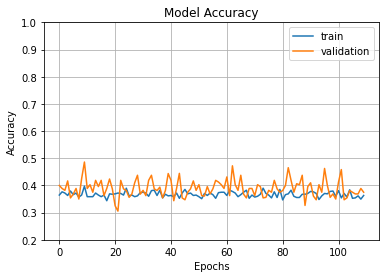

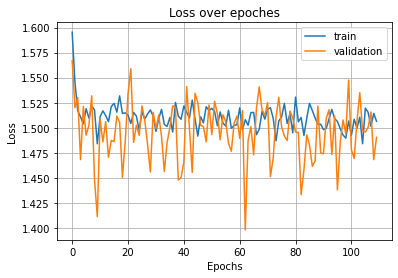

In [11]:

acc_history = [*best_model_history.history['accuracy'], *history.history['accuracy']]
val_acc_history = [*best_model_history.history['val_accuracy'], *history.history['val_accuracy']]
loss_history = [*best_model_history.history['loss'], *history.history['loss']]
val_loss_history = [*best_model_history.history['val_loss'], *history.history['val_loss']]

fig1 = plt.gcf()
plt.plot(acc_history)
plt.plot(val_acc_history)
plt.axis(ymin=0.2,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig1 = plt.gcf()
plt.plot(loss_history)
plt.plot(val_loss_history)
# plt.axis(ymin=0.2,ymax=1)
plt.grid()
plt.title('Loss over epoches')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

2022-02-03 13:10:22.676359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-03 13:12:04.961370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


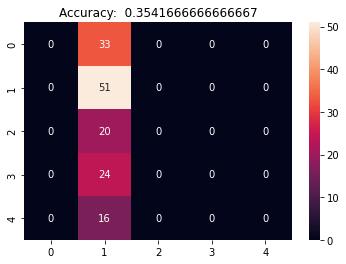

In [13]:

y_test = []
y_predict = []

for images, labels in test_dataset:
    tmp_predict = best_pre_model.predict(images)
    tmp_true_max = np.argmax(labels.numpy(), axis=1).astype(np.uint8)
    tmp_pred_max = np.argmax(tmp_predict, axis=1).astype(np.uint8)
    for y in tmp_true_max:
        y_test.append(y)
    for y in tmp_pred_max:
        y_predict.append(y)


cm = confusion_mtrx(y_test, y_predict)
sn.heatmap(cm ,annot = True)
acc = (np.array(y_test) == np.array(y_predict)).sum()/len(y_test)
plt.title("Accuracy:  "+str(acc))
plt.show()